In [172]:
from pathlib import Path

import geopandas as gdp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL 
from statsmodels.tsa.seasonal import seasonal_decompose

register_matplotlib_converters()

plt.rc('figure',figsize=(16,12))

## Variables

Variables available:

    - air temp
    - ice concentration
    - ice thickness
    - salinity
    - ocean temp
    
    
Data for ocean is only available from 2019 to roughly present.

In [203]:
pabrc_atmp_temp = xr.open_dataset('station-data/PABRC-temp.nc')

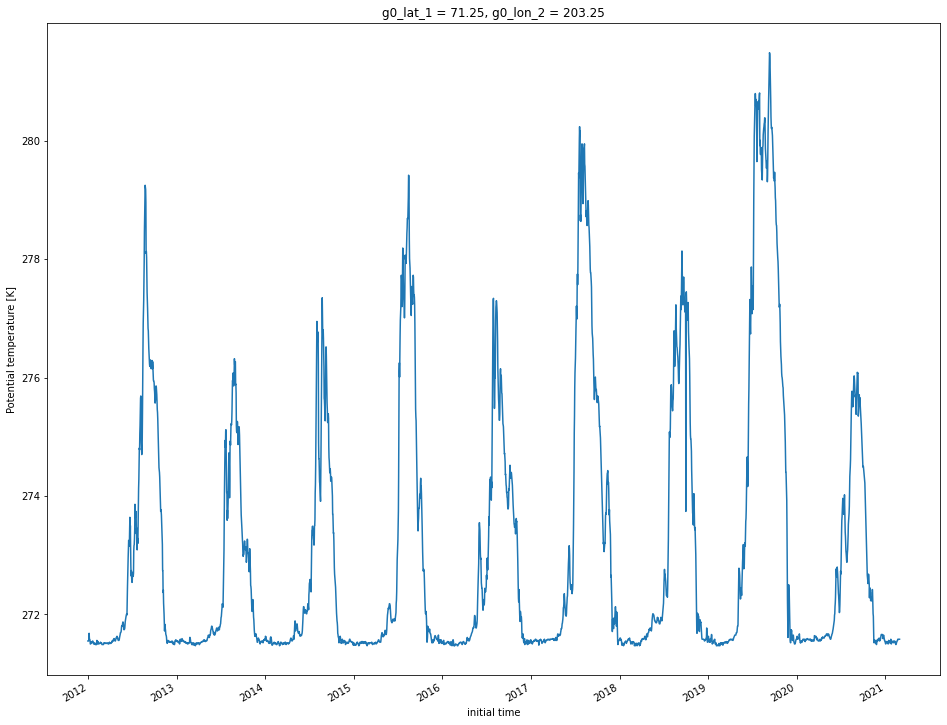

In [204]:
pabrc_atm_temp['POT_GDS0_DBSL_ave6h'].plot()

In [5]:
pabrc_ice_conc = xr.open_dataset('station-data/PABRC-ice_conc.nc')

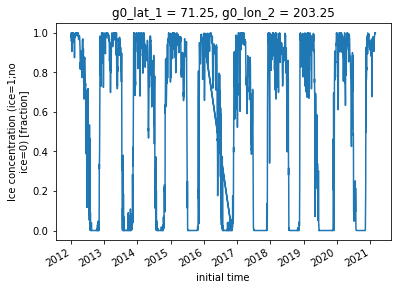

In [6]:
pabrc_ice_conc['ICE_C_GDS0_SFC_ave6h'].plot()

In [7]:
pabrc_ice_thk = xr.open_dataset('station-data/PABRC-ice_thk.nc')

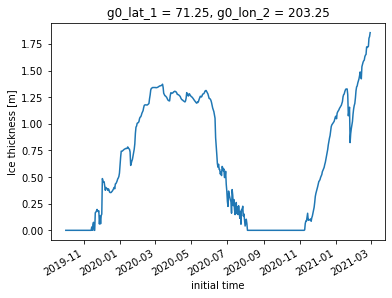

In [8]:
pabrc_ice_thk['ICETK_GDS0_SFC_ave6h'].plo

In [9]:
pabrc_salt = xr.open_dataset('station-data/PABRC-salt.nc')

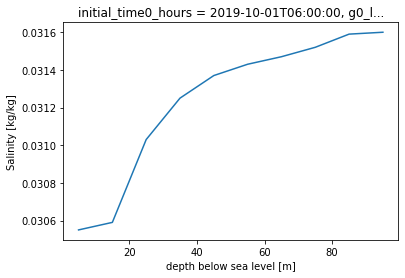

In [10]:
pabrc_salt['SALTY_GDS0_DBSL_ave6h'][0].plot()

In [11]:
ds_at, ds_s, ds_ice = xr.align(pabrc_atm_temp, pabrc_salt, pabrc_ice_thk, join='outer')

In [12]:
all_ds = xr.merge([ds_at, ds_s, ds_ice])

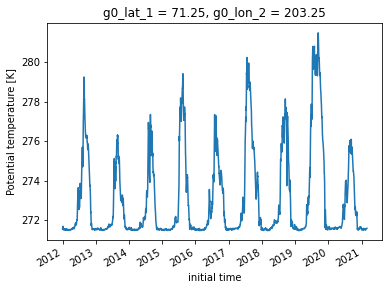

In [13]:
all_ds['POT_GDS0_DBSL_ave6h'].plot()

In [16]:
all_ds

<xarray.Dataset>
Dimensions:                (initial_time0_hours: 3345, lv_DBSL3: 11)
Coordinates:
  * initial_time0_hours    (initial_time0_hours) datetime64[ns] 2012-01-01T06...
    g0_lat_1               float32 71.25
    g0_lon_2               float32 203.2
  * lv_DBSL3               (lv_DBSL3) int32 5 15 25 35 45 55 65 75 85 95 105
Data variables:
    POT_GDS0_DBSL_ave6h    (initial_time0_hours) float32 ...
    SALTY_GDS0_DBSL_ave6h  (initial_time0_hours, lv_DBSL3) float32 nan ... nan
    ICETK_GDS0_SFC_ave6h   (initial_time0_hours) float32 nan nan ... 1.819 1.857

## Try seasonal trend decomposition

In [28]:
from statsmodels.tsa.seasonal import STL

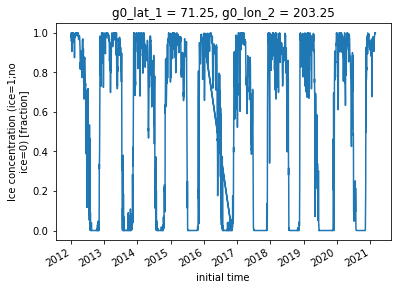

In [63]:
# a time is out of order :/ 
pabrc_ice_conc['ICE_C_GDS0_SFC_ave6h'].plot()

In [22]:
ice_times = pabrc_ice_conc['initial_time0_hours'].values

In [30]:
np.diff(ice_times).min()

numpy.timedelta64(-26352000000000000,'ns')

In [31]:
np.argmin(np.diff(ice_times))

1460

In [35]:
ice_times[1458:1462]

array(['2015-12-30T06:00:00.000000000', '2015-12-31T06:00:00.000000000',
       '2016-11-01T06:00:00.000000000', '2016-01-01T06:00:00.000000000'],
      dtype='datetime64[ns]')

In [37]:
np.argmax(np.diff(ice_times))

1459

In [47]:
len(ice_times)

3346

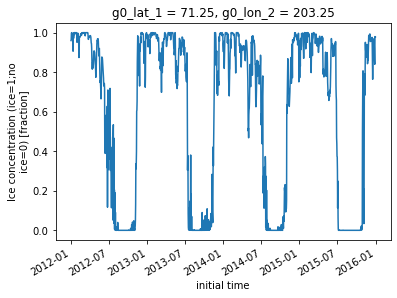

In [50]:
pabrc_ice_conc['ICE_C_GDS0_SFC_ave6h'].isel(initial_time0_hours=range(1460)).plot()

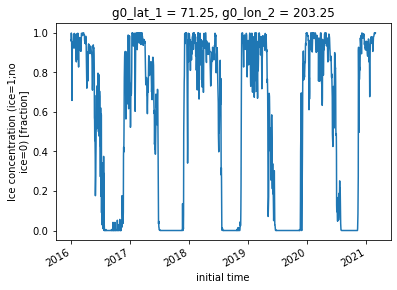

In [51]:
pabrc_ice_conc['ICE_C_GDS0_SFC_ave6h'].isel(initial_time0_hours=range(1461, 3346)).plot()

In [52]:
part_a = pabrc_ice_conc['ICE_C_GDS0_SFC_ave6h'].isel(initial_time0_hours=range(1460))
part_b = pabrc_ice_conc['ICE_C_GDS0_SFC_ave6h'].isel(initial_time0_hours=range(1461, 3346))

In [58]:
part_a

<xarray.DataArray 'ICE_C_GDS0_SFC_ave6h' (initial_time0_hours: 1460)>
array([0.96 , 0.965, 0.998, ..., 0.98 , 0.977, 0.978], dtype=float32)
Coordinates:
  * initial_time0_hours  (initial_time0_hours) datetime64[ns] 2012-01-01T06:0...
    g0_lat_1             float32 71.25
    g0_lon_2             float32 203.2
Attributes:
    sub_center:               Environmental Modeling Center
    center:                   US National Weather Service - NCEP (WMC)
    long_name:                Ice concentration (ice=1;no ice=0)
    units:                    fraction
    level_indicator:          1
    gds_grid_type:            0
    parameter_table_version:  2
    parameter_number:         91
    model:                    Analysis from GDAS (Global Data Assimilation Sy...
    forecast_time:            1
    forecast_time_units:      6 hours

In [61]:
pabrc_ice_conc_fixed = xr.concat([part_a, part_b], dim='initial_time0_hours')

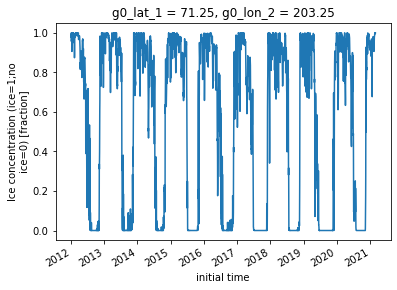

In [62]:
pabrc_ice_conc_fixed.plot()

In [99]:
pabrc_ice_conc_fixed

<xarray.DataArray 'ICE_C_GDS0_SFC_ave6h' (initial_time0_hours: 3345)>
array([0.96 , 0.965, 0.998, ..., 1.   , 1.   , 1.   ], dtype=float32)
Coordinates:
  * initial_time0_hours  (initial_time0_hours) datetime64[ns] 2012-01-01T06:0...
    g0_lat_1             float32 71.25
    g0_lon_2             float32 203.2
Attributes:
    sub_center:               Environmental Modeling Center
    center:                   US National Weather Service - NCEP (WMC)
    long_name:                Ice concentration (ice=1;no ice=0)
    units:                    fraction
    level_indicator:          1
    gds_grid_type:            0
    parameter_table_version:  2
    parameter_number:         91
    model:                    Analysis from GDAS (Global Data Assimilation Sy...
    forecast_time:            1
    forecast_time_units:      6 hours

In [68]:
# need to provide seasonal... what is this?
# 
stl = STL(pabrc_ice_conc_fixed, seasonal=13)
res = stl.fit()
fig = res.plot()

ValueError: Unable to determine period from endog

In [132]:
# need to put the data into a dataframe
ice_conc = pd.Series(
    pabrc_ice_conc_fixed.values,
    index=pabrc_ice_conc_fixed['initial_time0_hours'].values
)

In [142]:
ice_conc

2012-01-01 06:00:00    0.960
2012-01-02 06:00:00    0.965
2012-01-03 06:00:00    0.998
2012-01-04 06:00:00    0.999
2012-01-05 06:00:00    1.000
                       ...  
2021-02-24 06:00:00    0.996
2021-02-25 06:00:00    0.995
2021-02-26 06:00:00    1.000
2021-02-27 06:00:00    1.000
2021-02-28 06:00:00    1.000
Length: 3345, dtype: float32

seasonal=365, period=365, trend=547, low_pass=367


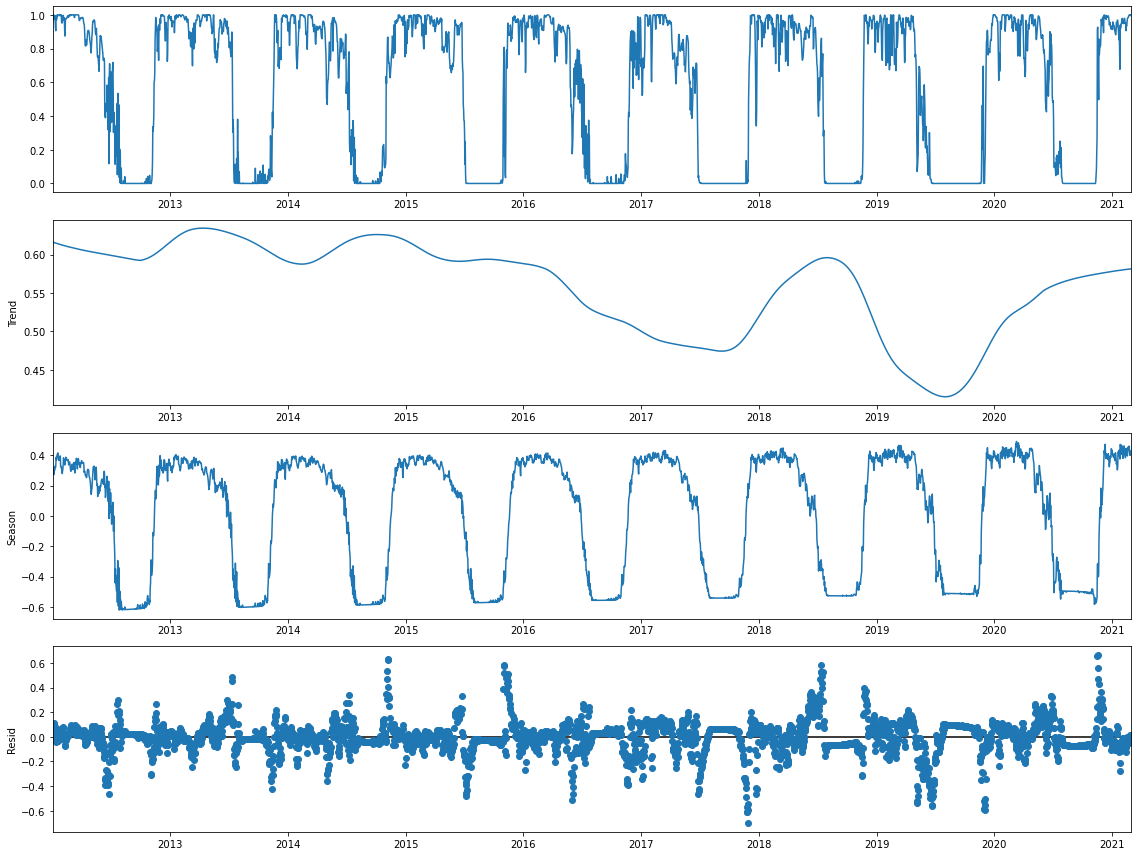

In [171]:
# seasonal - length of seasonal smoother
# - monthly? seasonally (90 days)?  annually?
seasonal = 365
period = 365

trend = int(seasonal * 1.5)
if trend % 2 == 0:
    trend += 1

# from doc, usually the smallest odd number > period
if period % 2 == 0:
    low_pass = period + 1
else:
    low_pass = period + 2
    
print(f'seasonal={seasonal}, period={period}, trend={trend}, low_pass={low_pass}')
    
stl = STL(ice_conc, period=period, seasonal=seasonal, trend=trend)
res = stl.fit()
fig = res.plot()

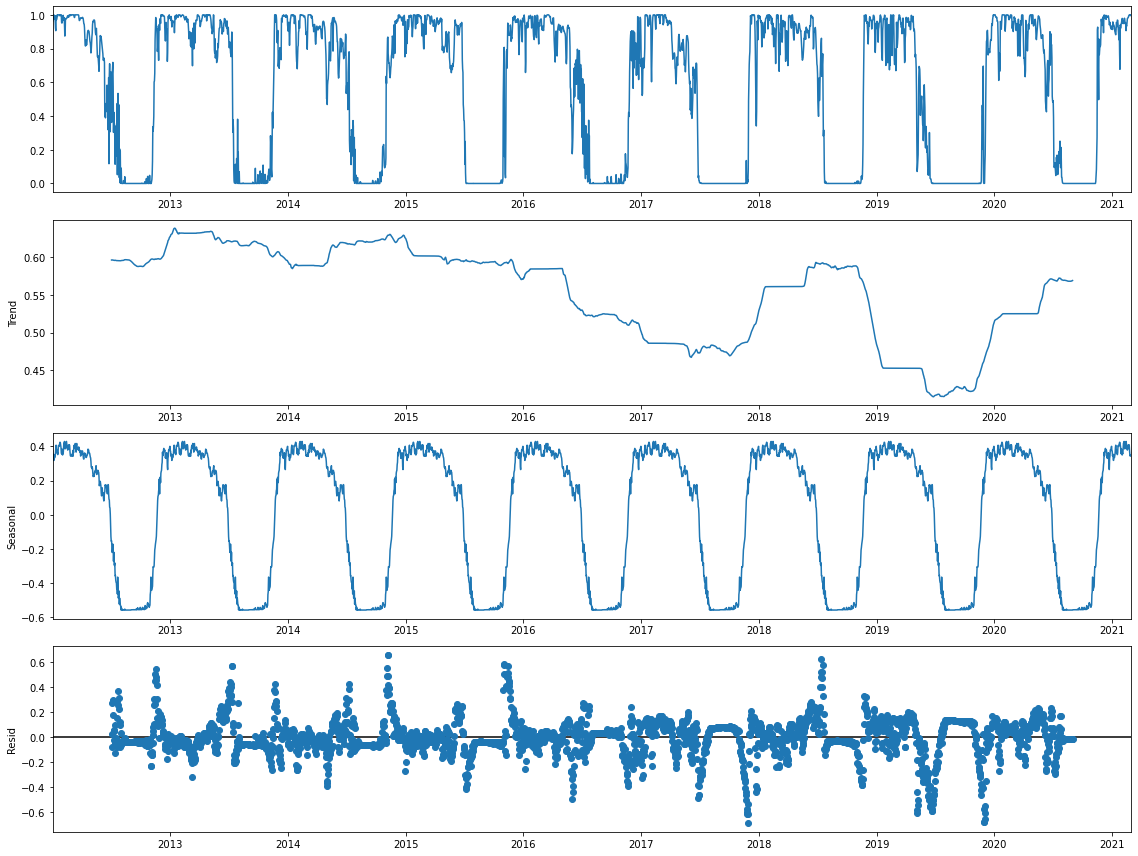

In [182]:
decomposed = seasonal_decompose(ice_conc, model='additive', period=365)
decomposed.plot()

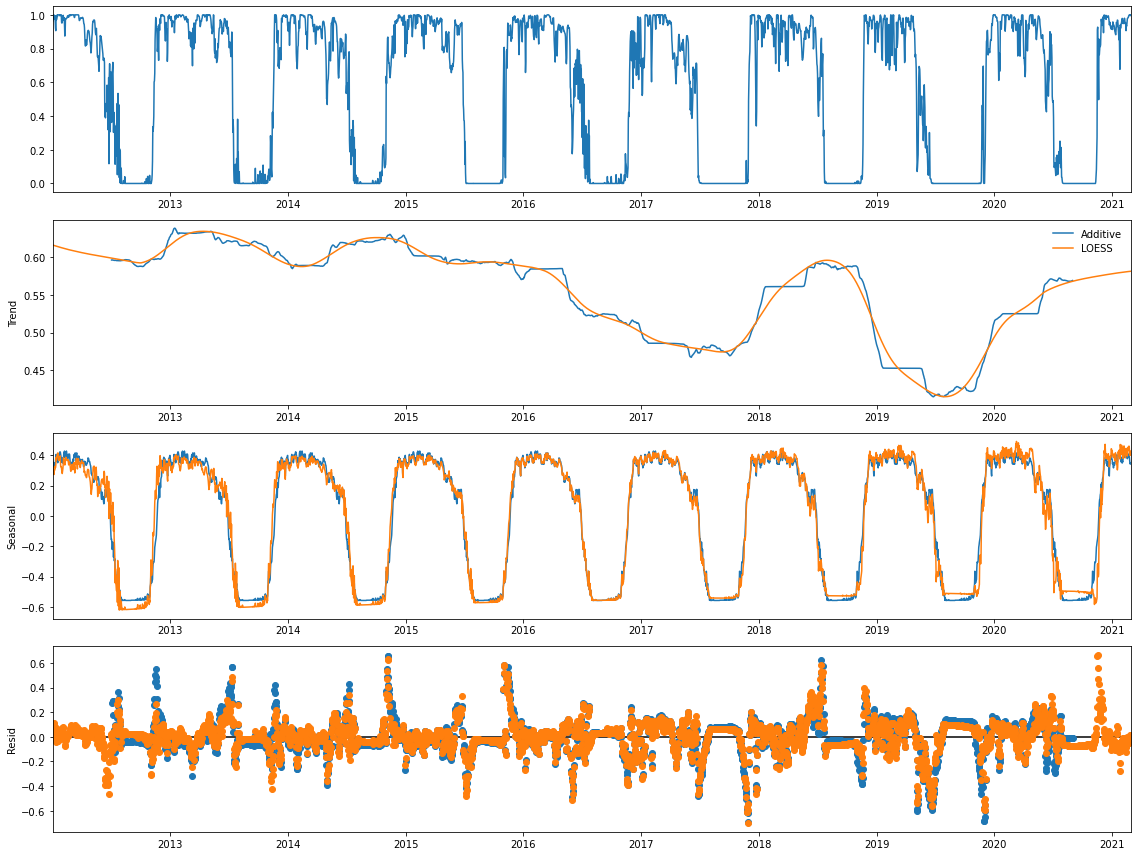

In [184]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(legend, frameon=False)
                
fig = decomposed.plot()
add_stl_plot(fig, res, ['Additive', 'LOESS'])

In [185]:
# Try forecast

In [186]:
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

In [201]:
ice_conc.index.inferred_freq = 'D'

#stl_forecast = STLForecast(ice_conc, ARIMA, period=period, seasonal=seasonal, trend=trend, model_kwargs=dict(order=(1,1,0), trend='t'))

AttributeError: Can't set attribute